# **ArtLine**
**Create** **amazing** **lineart** **portraits** 


In [2]:
import fastai
from fastai.vision import *
from fastai.utils.mem import *
from fastai.vision import open_image, load_learner, image, torch
import numpy as np
import urllib.request
import PIL.Image
from io import BytesIO
import torchvision.transforms as T
from PIL import Image
import requests
from io import BytesIO
import fastai
from fastai.vision import *
from fastai.utils.mem import *
from fastai.vision import open_image, load_learner, image, torch
import numpy as np
import urllib.request
import PIL.Image
from PIL import Image
from io import BytesIO
import torchvision.transforms as T

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

def add_margin(pil_img, top, right, bottom, left, color):
    width, height = pil_img.size
    new_width = width + right + left
    new_height = height + top + bottom
    result = Image.new(pil_img.mode, (new_width, new_height), color)
    result.paste(pil_img, (left, top))
    return result

In [3]:
#MODEL_URL = "https://www.dropbox.com/s/04suaimdpru76h3/ArtLine_920.pkl?dl=1 "
#urllib.request.urlretrieve(MODEL_URL, "ArtLine_920.pkl")
path = Path(".")
learn=load_learner(path, 'ArtLine_920.pkl')

In [4]:
url = 'https://filmspell.com/wp-content/uploads/2019/12/ford-ferrari-anatomy-promo-videoSixteenByNine1050-990x556.jpg' 

response = requests.get(url)


In [5]:
img = PIL.Image.open(BytesIO(response.content)).convert("RGB")

In [6]:
im_new = add_margin(img, 250, 250, 250, 250, (255, 255, 255))
im_new.save("test.jpg", quality=95)
img = open_image("test.jpg")

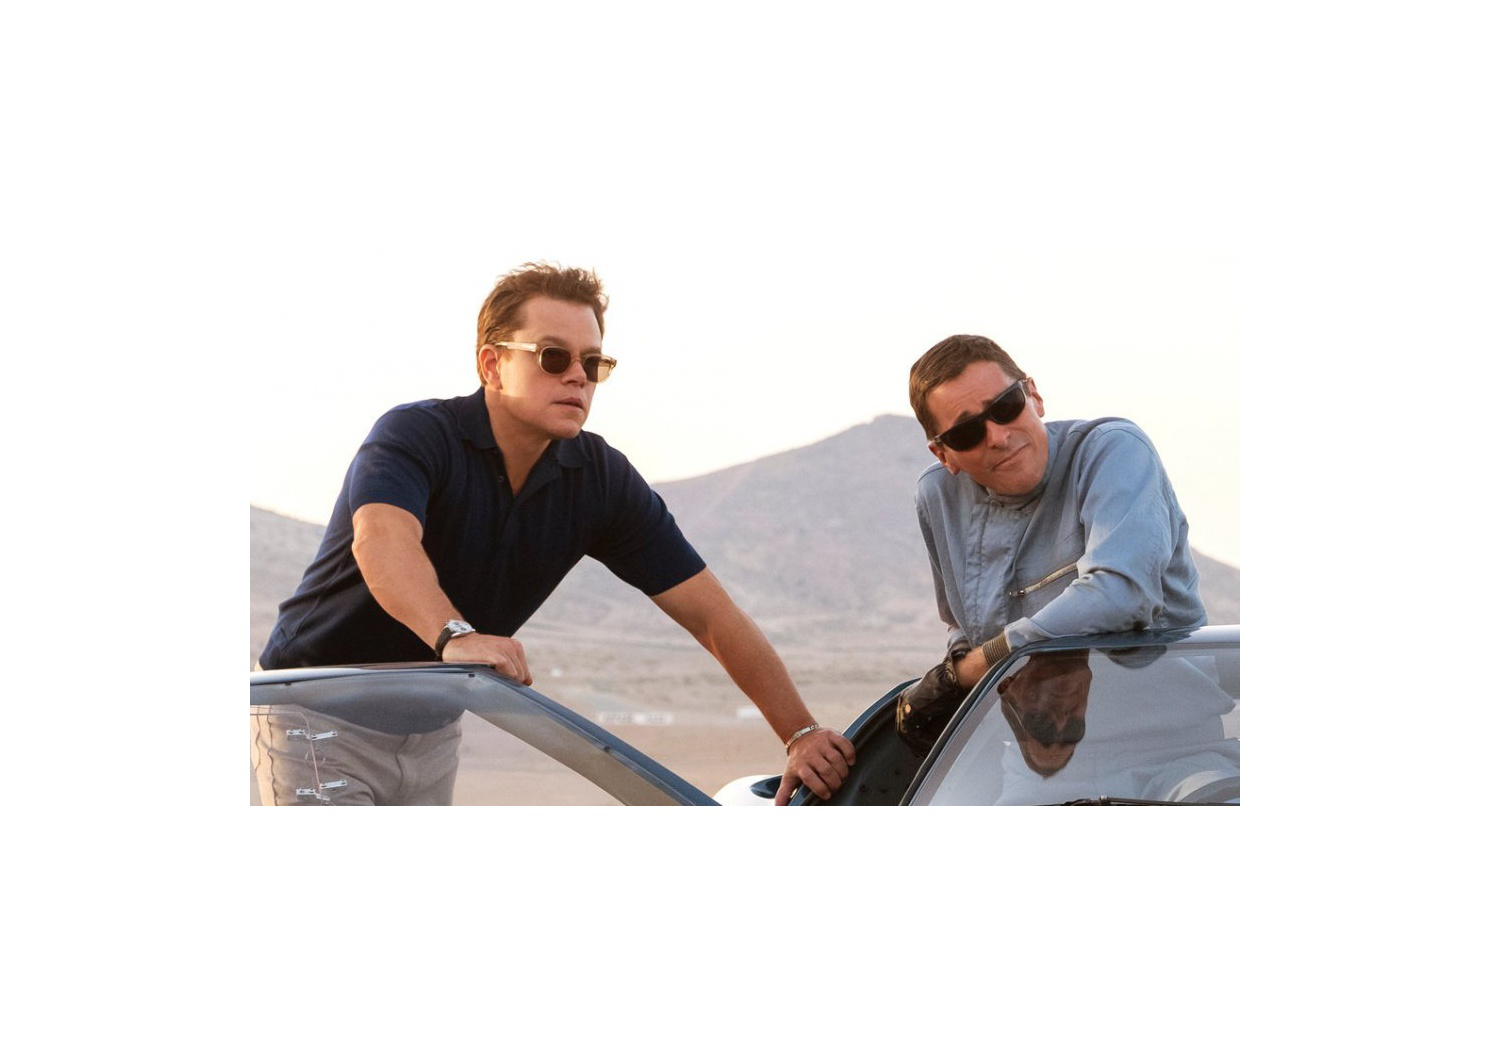

In [12]:
img

In [7]:
p,img_hr,b = learn.predict(img)

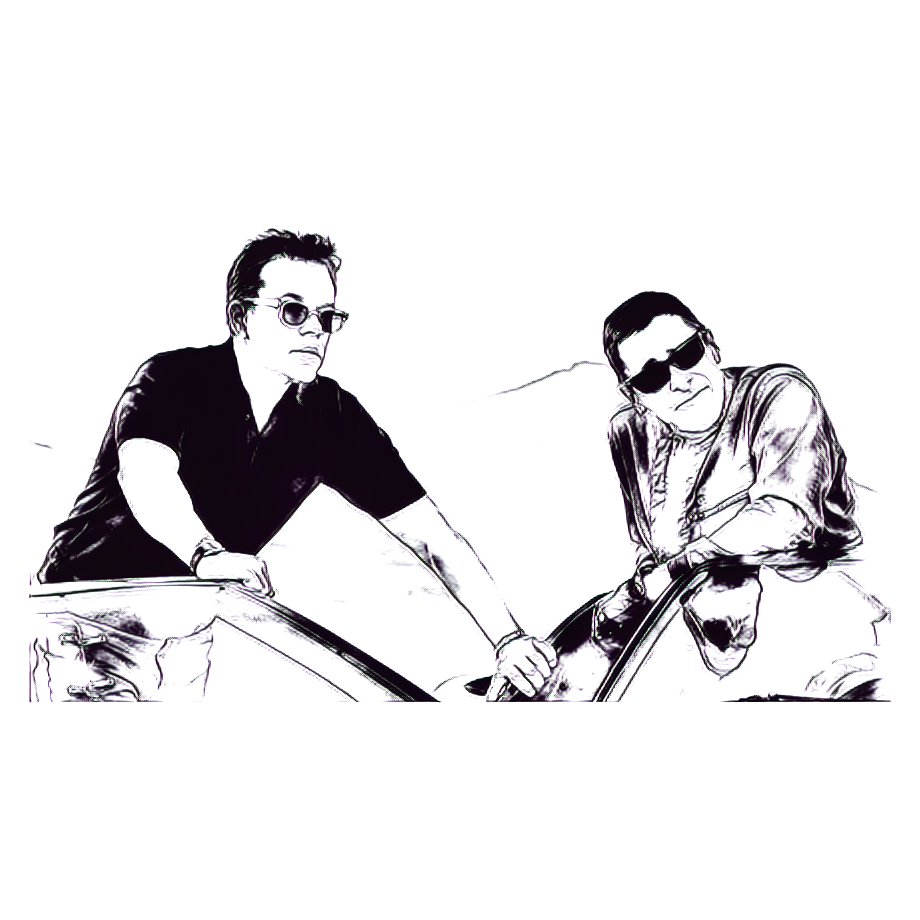

In [11]:
p